<a href="https://colab.research.google.com/github/vishnuvryeruva/transfer-learning-and-supervised-contrastive-learning/blob/main/Supervised_Contrastive_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

import datetime
import numpy as np
import tensorflow as tf


import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
!pip install tensorflow-addons==0.16.1
import tensorflow_addons as tfa

     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [17]:
import sys
import os

py_file_location = "/content/drive/MyDrive"
sys.path.append(os.path.abspath(py_file_location))

In [19]:
from model import *
import losses

In [20]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [21]:
# global configs
EPOCHS = 20
# DATA = 'mnist'
DATA = 'fashion_mnist'
NORMALIZE_EMBEDDING = True
# NORMALIZE_EMBEDDING = False
N_DATA_TRAIN = 60000
# BATCH_SIZE = 32
BATCH_SIZE = 1024 # batch_size for pre-training
PROJECTION_DIM = 128
# WRITE_SUMMARY = True
WRITE_SUMMARY = False

ACTIVATION = 'leaky_relu'
LR = 0.5 # learning rate for pre-training

In [22]:
!mkdir -p logs/

In [23]:
optimizer = tf.keras.optimizers.Adam(lr=LR)
optimizer2 = tf.keras.optimizers.Adam() # with default lr

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [24]:
if DATA == 'mnist':
    mnist = tf.keras.datasets.mnist
elif DATA == 'fashion_mnist':
    mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(-1, 28*28).astype(np.float32)
x_test = x_test.reshape(-1, 28*28).astype(np.float32)
print(x_train.shape, x_test.shape)

4431872/4422102 [==============================] - 0s 0us/step
(60000, 784) (10000, 784)


In [25]:
# simulate low data regime for training
n_train = x_train.shape[0]
shuffle_idx = np.arange(n_train)
np.random.shuffle(shuffle_idx)

x_train = x_train[shuffle_idx][:N_DATA_TRAIN]
y_train = y_train[shuffle_idx][:N_DATA_TRAIN]
print(x_train.shape, y_train.shape)

(60000, 784) (60000,)


In [26]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(5000).batch(BATCH_SIZE)

train_ds2 = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(5000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

Stage 1: train encoder with multiclass N-pair loss

In [28]:
encoder = Encoder(normalize=NORMALIZE_EMBEDDING, activation=ACTIVATION)
projector = Projector(PROJECTION_DIM, normalize=NORMALIZE_EMBEDDING, activation=ACTIVATION)

In [29]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [30]:
@tf.function
# train step for the multiclass N-pair loss
def train_step_npair(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:        
        r = encoder(x, training=True)
        z = projector(r, training=True)
        loss = losses.multiclass_npairs_loss(z, y)

    gradients = tape.gradient(loss, 
                              encoder.trainable_variables + projector.trainable_variables)
    optimizer.apply_gradients(zip(gradients, 
                                  encoder.trainable_variables + projector.trainable_variables))
    train_loss(loss)

In [31]:
@tf.function
def test_step_npair(x, y):
    r = encoder(x, training=False)
    z = projector(r, training=False)
    t_loss = losses.multiclass_npairs_loss(z, y)
    test_loss(t_loss)

In [32]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    test_loss.reset_states()

    for x, y in train_ds:
        train_step_npair(x, y)

    for x_te, y_te in test_ds:
        test_step_npair(x_te, y_te)

    template = 'Epoch {}, Loss: {}, Test Loss: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        test_loss.result()))

Epoch 1, Loss: 6.416479587554932, Test Loss: 6.330545425415039
Epoch 2, Loss: 6.317351818084717, Test Loss: 6.282464504241943
Epoch 3, Loss: 6.283580780029297, Test Loss: 6.265687942504883
Epoch 4, Loss: 6.261178016662598, Test Loss: 6.246984481811523
Epoch 5, Loss: 6.251001358032227, Test Loss: 6.237180709838867
Epoch 6, Loss: 6.243208885192871, Test Loss: 6.227005481719971
Epoch 7, Loss: 6.233121871948242, Test Loss: 6.217827796936035
Epoch 8, Loss: 6.223102569580078, Test Loss: 6.206856727600098
Epoch 9, Loss: 6.212066173553467, Test Loss: 6.205040454864502
Epoch 10, Loss: 6.206756114959717, Test Loss: 6.197767734527588
Epoch 11, Loss: 6.200307369232178, Test Loss: 6.194814682006836
Epoch 12, Loss: 6.199061870574951, Test Loss: 6.18678617477417
Epoch 13, Loss: 6.19401741027832, Test Loss: 6.188201427459717
Epoch 14, Loss: 6.1940107345581055, Test Loss: 6.190431594848633
Epoch 15, Loss: 6.189396381378174, Test Loss: 6.183584690093994
Epoch 16, Loss: 6.18723201751709, Test Loss: 6.178

In [33]:
x_tr_proj = projector(encoder(x_train))
x_tr_proj.shape

TensorShape([60000, 256])

In [34]:
x_te_proj = projector(encoder(x_test))
x_te_proj.shape

TensorShape([10000, 256])

In [35]:
# convert tensor to np.array
x_tr_proj = x_tr_proj.numpy()
x_te_proj = x_te_proj.numpy()
print(x_tr_proj.shape, x_te_proj.shape)

(60000, 256) (10000, 256)


Check learned embedding

In [36]:
# do PCA for the projected data
pca = PCA(n_components=2)
pca.fit(x_tr_proj)
x_te_proj_pca = pca.transform(x_te_proj)
x_te_proj_pca.shape

(10000, 2)

In [37]:
# do PCA for original data
pca = PCA(n_components=2)
pca.fit(x_train)
x_te_pca = pca.transform(x_test)
x_te_pca.shape

(10000, 2)

In [38]:
x_te_proj_df = pd.DataFrame(x_te_proj[:, :2], columns=['Proj1', 'Proj2'])
x_te_proj_df['label'] = y_test

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


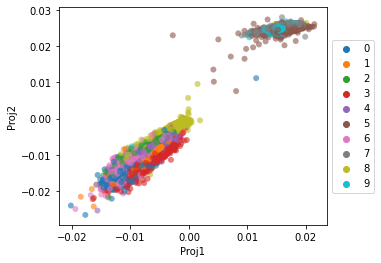

In [39]:
ax = sns.scatterplot('Proj1', 'Proj2', data=x_te_proj_df,
                palette='tab10',
                hue='label',
                linewidth=0,
                alpha=0.6
               )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [40]:
x_te_proj_pca_df = pd.DataFrame(x_te_proj_pca, columns=['PC1', 'PC2'])
x_te_proj_pca_df['label'] = y_test

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


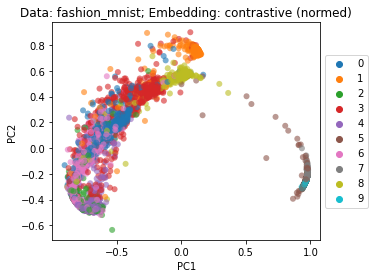

In [41]:
fig, ax = plt.subplots()
ax = sns.scatterplot('PC1', 'PC2', 
                     data=x_te_proj_pca_df,
                     palette='tab10',
                     hue='label',
                     linewidth=0,
                     alpha=0.6,
                     ax=ax
               );

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
title = 'Data: %s; Embedding: contrastive'% DATA
if NORMALIZE_EMBEDDING:
    title = 'Data: %s; Embedding: contrastive (normed)'% DATA
ax.set_title(title);

In [42]:
x_te_pca_df = pd.DataFrame(x_te_pca, columns=['PC1', 'PC2'])
x_te_pca_df['label'] = y_test

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


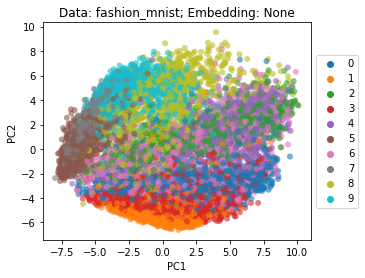

In [43]:
fig, ax = plt.subplots()
ax = sns.scatterplot('PC1', 'PC2', data=x_te_pca_df,
                palette='tab10',
                hue='label',
                linewidth=0,
                alpha=0.6,
                     ax=ax
               )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

title = 'Data: %s; Embedding: None'% DATA
ax.set_title(title);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


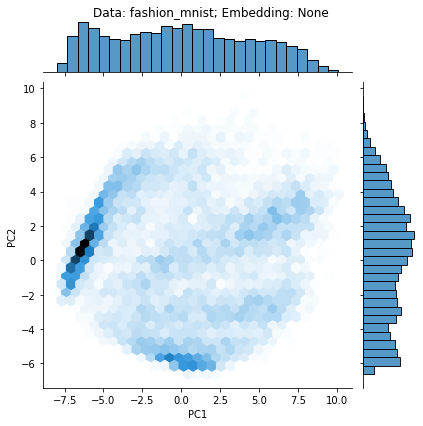

In [44]:
g = sns.jointplot('PC1', 'PC2', data=x_te_pca_df,
              kind="hex"
             );

plt.subplots_adjust(top=0.95)
g.fig.suptitle(title);

In [45]:
softmax = SoftmaxPred()

In [46]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_ACC')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_ACC')

In [47]:
cce_loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [48]:
@tf.function
# train step for the 2nd stage
def train_step(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:        
        r = encoder(x, training=False)
        y_preds = softmax(r, training=True)
        loss = cce_loss_obj(y, y_preds)

    # freeze the encoder, only train the softmax layer
    gradients = tape.gradient(loss, 
                              softmax.trainable_variables) 
    optimizer2.apply_gradients(zip(gradients, 
                                  softmax.trainable_variables))

    train_loss(loss)
    train_acc(y, y_preds)

In [49]:
@tf.function
def test_step(x, y):
    r = encoder(x, training=False)
    y_preds = softmax(r, training=False)
    t_loss = cce_loss_obj(y, y_preds)
    test_loss(t_loss)
    test_acc(y, y_preds)

In [50]:
model_name = 'contrast_loss_model'
if not NORMALIZE_EMBEDDING:
    model_name = 'contrast_loss_model-no_norm'
if WRITE_SUMMARY:
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/%s/%s/%s/train' % (model_name, DATA, current_time)
    test_log_dir = 'logs/%s/%s/%s/test' % (model_name, DATA, current_time)
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [51]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()

    for x, y in train_ds2:
        train_step(x, y)

    if WRITE_SUMMARY:
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', train_acc.result(), step=epoch)        
        
    for x_te, y_te in test_ds:
        test_step(x_te, y_te)

    if WRITE_SUMMARY:
        with test_summary_writer.as_default():
            tf.summary.scalar('loss', test_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', test_acc.result(), step=epoch)        
        
    template = 'Epoch {}, Loss: {}, Acc: {}, Test Loss: {}, Test Acc: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_acc.result() * 100,
                        test_loss.result(),
                        test_acc.result() * 100))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epoch 1, Loss: 0.9225476384162903, Acc: 72.59833526611328, Test Loss: 0.667755663394928, Test Acc: 76.59000396728516
Epoch 2, Loss: 0.5875987410545349, Acc: 79.26333618164062, Test Loss: 0.5995142459869385, Test Acc: 78.1500015258789
Epoch 3, Loss: 0.5430315136909485, Acc: 80.5433349609375, Test Loss: 0.5745949745178223, Test Acc: 79.5
Epoch 4, Loss: 0.5232425332069397, Acc: 81.2683334350586, Test Loss: 0.5618878602981567, Test Acc: 80.11000061035156
Epoch 5, Loss: 0.5115200877189636, Acc: 81.62833404541016, Test Loss: 0.5539306402206421, Test Acc: 79.97000122070312
Epoch 6, Loss: 0.5034894943237305, Acc: 81.84500122070312, Test Loss: 0.5470433831214905, Test Acc: 80.5
Epoch 7, Loss: 0.4973476827144623, Acc: 82.09000396728516, Test Loss: 0.541685938835144, Test Acc: 80.72999572753906
Epoch 8, Loss: 0.49240443110466003, Acc: 82.22000122070312, Test Loss: 0.5375038981437683, Test Acc: 80.83999633789062
Epoch 9, Loss: 0.48800066113471985, Acc: 82.45000457763672, Test Loss: 0.5346621274948

In [52]:
test_acc.result().numpy()

0.8171

In [53]:
encoder = Encoder(normalize=NORMALIZE_EMBEDDING, activation=ACTIVATION)
projector = Projector(PROJECTION_DIM, normalize=NORMALIZE_EMBEDDING, activation=ACTIVATION)

In [54]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [55]:
@tf.function
# train step for the multiclass N-pair loss
def train_step_sup_nt_xent(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:        
        r = encoder(x, training=True)
        z = projector(r, training=True)
        loss = losses.supervised_nt_xent_loss(z, y, temperature=0.1)

    gradients = tape.gradient(loss, 
                              encoder.trainable_variables + projector.trainable_variables)
    optimizer.apply_gradients(zip(gradients, 
                                  encoder.trainable_variables + projector.trainable_variables))
    train_loss(loss)

In [56]:
@tf.function
def test_step_sup_nt_xent(x, y):
    r = encoder(x, training=False)
    z = projector(r, training=False)
    t_loss = losses.supervised_nt_xent_loss(z, y, temperature=0.1)
    test_loss(t_loss)

In [57]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    test_loss.reset_states()

    for x, y in train_ds:
        train_step_sup_nt_xent(x, y)

    for x_te, y_te in test_ds:
        test_step_sup_nt_xent(x_te, y_te)

    template = 'Epoch {}, Loss: {}, Test Loss: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        test_loss.result()))

Epoch 1, Loss: 8.721633911132812, Test Loss: 8.54892349243164
Epoch 2, Loss: 8.494733810424805, Test Loss: 8.43833065032959
Epoch 3, Loss: 8.404861450195312, Test Loss: 8.358482360839844
Epoch 4, Loss: 8.318536758422852, Test Loss: 8.289640426635742
Epoch 5, Loss: 8.26003360748291, Test Loss: 8.245137214660645
Epoch 6, Loss: 8.213875770568848, Test Loss: 8.204302787780762
Epoch 7, Loss: 8.170088768005371, Test Loss: 8.166654586791992
Epoch 8, Loss: 8.120179176330566, Test Loss: 8.106790542602539
Epoch 9, Loss: 8.05217456817627, Test Loss: 8.053604125976562
Epoch 10, Loss: 7.983471870422363, Test Loss: 7.973113059997559
Epoch 11, Loss: 7.916550159454346, Test Loss: 7.888450622558594
Epoch 12, Loss: 7.815268516540527, Test Loss: 7.834819793701172
Epoch 13, Loss: 7.748138427734375, Test Loss: 7.780619144439697
Epoch 14, Loss: 7.704622268676758, Test Loss: 7.744223117828369
Epoch 15, Loss: 7.671789169311523, Test Loss: 7.749882698059082
Epoch 16, Loss: 7.63911247253418, Test Loss: 7.697592

In [58]:
x_tr_proj = projector(encoder(x_train))
x_tr_proj.shape

TensorShape([60000, 256])

In [59]:
x_te_proj = projector(encoder(x_test))
x_te_proj.shape

TensorShape([10000, 256])

In [60]:
# convert tensor to np.array
x_tr_proj = x_tr_proj.numpy()
x_te_proj = x_te_proj.numpy()
print(x_tr_proj.shape, x_te_proj.shape)

(60000, 256) (10000, 256)


Check learned embedding

In [61]:
# do PCA for the projected data
pca = PCA(n_components=2)
pca.fit(x_tr_proj)
x_te_proj_pca = pca.transform(x_te_proj)
x_te_proj_pca.shape

(10000, 2)

In [62]:
# do PCA for original data
pca = PCA(n_components=2)
pca.fit(x_train)
x_te_pca = pca.transform(x_test)
x_te_pca.shape

(10000, 2)

In [63]:
x_te_proj_df = pd.DataFrame(x_te_proj[:, :2], columns=['Proj1', 'Proj2'])
x_te_proj_df['label'] = y_test

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


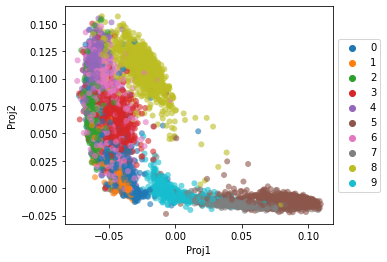

In [64]:
ax = sns.scatterplot('Proj1', 'Proj2', data=x_te_proj_df,
                palette='tab10',
                hue='label',
                linewidth=0,
                alpha=0.6
               )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [65]:
x_te_proj_pca_df = pd.DataFrame(x_te_proj_pca, columns=['PC1', 'PC2'])
x_te_proj_pca_df['label'] = y_test

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


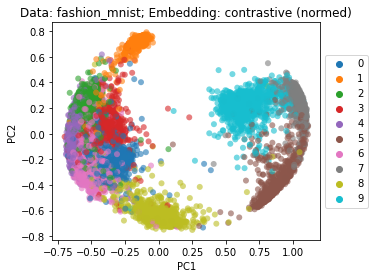

In [66]:
fig, ax = plt.subplots()
ax = sns.scatterplot('PC1', 'PC2', 
                     data=x_te_proj_pca_df,
                     palette='tab10',
                     hue='label',
                     linewidth=0,
                     alpha=0.6,
                     ax=ax
               );

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
title = 'Data: %s; Embedding: contrastive'% DATA
if NORMALIZE_EMBEDDING:
    title = 'Data: %s; Embedding: contrastive (normed)'% DATA
ax.set_title(title);

In [67]:
x_te_pca_df = pd.DataFrame(x_te_pca, columns=['PC1', 'PC2'])
x_te_pca_df['label'] = y_test

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


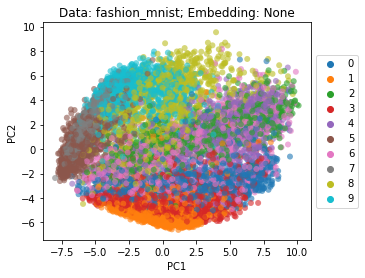

In [68]:
fig, ax = plt.subplots()
ax = sns.scatterplot('PC1', 'PC2', data=x_te_pca_df,
                palette='tab10',
                hue='label',
                linewidth=0,
                alpha=0.6,
                     ax=ax
               )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

title = 'Data: %s; Embedding: None'% DATA
ax.set_title(title);

In [69]:
softmax = SoftmaxPred()

In [70]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_ACC')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_ACC')

In [72]:
cce_loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [73]:
@tf.function
# train step for the 2nd stage
def train_step(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:        
        r = encoder(x, training=False)
        y_preds = softmax(r, training=True)
        loss = cce_loss_obj(y, y_preds)

    # freeze the encoder, only train the softmax layer
    gradients = tape.gradient(loss, 
                              softmax.trainable_variables) 
    optimizer2.apply_gradients(zip(gradients, 
                                  softmax.trainable_variables))

    train_loss(loss)
    train_acc(y, y_preds)

In [74]:
@tf.function
def test_step(x, y):
    r = encoder(x, training=False)
    y_preds = softmax(r, training=False)

    t_loss = cce_loss_obj(y, y_preds)

    test_loss(t_loss)
    test_acc(y, y_preds)

In [75]:
model_name = 'contrast_loss_model'
if not NORMALIZE_EMBEDDING:
    model_name = 'contrast_loss_model-no_norm'
if WRITE_SUMMARY:
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/%s/%s/%s/train' % (model_name, DATA, current_time)
    test_log_dir = 'logs/%s/%s/%s/test' % (model_name, DATA, current_time)
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [76]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()

    for x, y in train_ds2:
        train_step(x, y)

    if WRITE_SUMMARY:
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', train_acc.result(), step=epoch)        
        
    for x_te, y_te in test_ds:
        test_step(x_te, y_te)

    if WRITE_SUMMARY:
        with test_summary_writer.as_default():
            tf.summary.scalar('loss', test_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', test_acc.result(), step=epoch)        
        
    template = 'Epoch {}, Loss: {}, Acc: {}, Test Loss: {}, Test Acc: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_acc.result() * 100,
                        test_loss.result(),
                        test_acc.result() * 100))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epoch 1, Loss: 0.8372613787651062, Acc: 77.72833251953125, Test Loss: 0.6652037501335144, Test Acc: 80.56999969482422
Epoch 2, Loss: 0.5813875198364258, Acc: 82.75666809082031, Test Loss: 0.5747202634811401, Test Acc: 82.01000213623047
Epoch 3, Loss: 0.5157684087753296, Acc: 83.9383316040039, Test Loss: 0.5312461853027344, Test Acc: 82.76000213623047
Epoch 4, Loss: 0.4811721444129944, Acc: 84.51166534423828, Test Loss: 0.5076926350593567, Test Acc: 83.18000030517578
Epoch 5, Loss: 0.46019282937049866, Acc: 84.93000030517578, Test Loss: 0.4914107918739319, Test Acc: 83.60000610351562
Epoch 6, Loss: 0.4462336599826813, Acc: 85.1933364868164, Test Loss: 0.4814450144767761, Test Acc: 83.67000579833984
Epoch 7, Loss: 0.4362858831882477, Acc: 85.37166595458984, Test Loss: 0.47364792227745056, Test Acc: 83.72000122070312
Epoch 8, Loss: 0.4288683831691742, Acc: 85.50833129882812, Test Loss: 0.46806564927101135, Test Acc: 83.75
Epoch 9, Loss: 0.42312225699424744, Acc: 85.63500213623047, Test Lo

In [78]:
test_acc.result().numpy()

0.8433